In [4]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install gluonts

  Using cached https://files.pythonhosted.org/packages/98/c8/113009b077ca127308470dcd4851e53a6b4ad905fe61f36f28d22ff3a4a5/gluonts-0.4.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d0/17/a452275a0b3e811a381137ff6a61649086af4c5bf2a25755f518cc64b39e/holidays-0.9.11.tar.gz
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c9/5e/0f54f9b340dc4a2153411be072d7af5e91f4a259aea880c9e9637b88f6de/pydantic-1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7f/32/5144caf0478b1f26bd9d97f510a47336cf4ac0f96c6bc3b5af20d4173920/tqdm-4.40.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org

In [6]:
import gluonts
gluonts.__version__

'0.4.2'

In [7]:
import mxnet
mxnet.__version__

'1.4.1'

In [8]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [20]:
dataname = "m4_monthly_other"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.


In [21]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [23]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train dataset 277
length test dataset 277


In [24]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'target': array([  504.63,   498.05,   497.33,   500.58,   501.12,   503.37,
          508.02,   506.61,   507.22,   506.6 ,   508.77,   515.04,
          506.61,   496.09,   494.82,   496.56,   497.34,   500.15,
          504.55,   502.79,   499.2 ,   501.3 ,   502.51,   497.63,
          491.03,   484.41,   483.62,   484.55,   484.94,   488.75,
          492.16,   493.34,   495.99,   500.32,   504.84,   512.81,
          506.03,   498.41,   500.24,   503.65,   505.43,   509.08,
          513.14,   511.75,   513.22,   515.52,   513.44,   522.57,
          516.35,   510.13,   512.06,   514.89,   517.02,   521.95,
          527.68,   526.  ,   529.1 ,   531.17,   537.75,   549.13,
          542.38,   534.72,   538.3 ,   540.52,   542.73,   549.4 ,
          554.26,   554.27,   558.87,   561.62,   567.86,   577.37,
          571.38,   565.08,   566.96,   570.89,   571.65,   577.61,
          584.07,   581.92,   585.74,   591.37,   59

## Plot Series

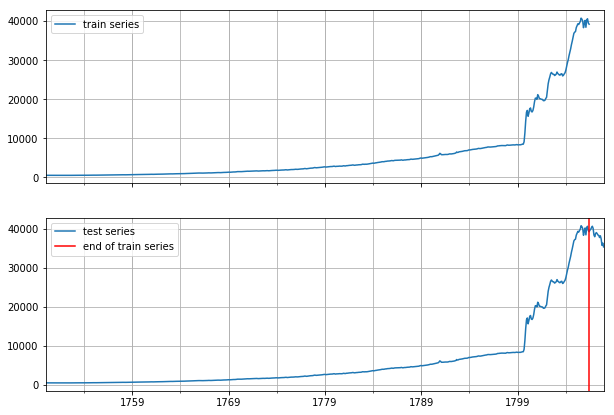

In [25]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [26]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [27]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [28]:
dataname

'm4_monthly_other'

In [31]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_monthly_other.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:04<00:00, 24.70it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[0] Elapsed time 4.050 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.010512
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.10it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[1] Elapsed time 3.834 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.233872
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.28it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[2] Elapsed time 3.807 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.040738
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[3] Elapsed time 3.828 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.960942
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.15it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:03<00:00, 25.91it/s, avg_epoch_loss=6.19]
INFO:root:Epoch[37] Elapsed time 3.861 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.187898
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.20it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[38] Elapsed time 3.818 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.129827
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[39] Elapsed time 3.813 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.052721
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[40] Elapsed time 3.828 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.121278
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[41] Elapsed time 3.844 second

100%|██████████| 100/100 [00:04<00:00, 23.20it/s, avg_epoch_loss=5.93]
INFO:root:Epoch[74] Elapsed time 4.313 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.926279
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.10it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[75] Elapsed time 3.985 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.875656
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.07it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[76] Elapsed time 3.838 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.910734
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[77] Elapsed time 3.842 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.854330
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.15it/s, avg_epoch_loss

100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[110] Elapsed time 3.842 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.822122
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.20it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[111] Elapsed time 3.821 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.798687
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 25.86it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[112] Elapsed time 3.871 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.779554
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 25.99it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[113] Elapsed time 3.852 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.791112
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.02it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[114] Elaps

100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[146] Elapsed time 3.844 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.758644
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.28it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[147] Elapsed time 3.807 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.715561
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[148] Elapsed time 3.818 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.745209
INFO:root:Loading parameters from best epoch (138)
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[149] Elapsed time 3.827 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.710719
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26

100%|██████████| 100/100 [00:03<00:00, 26.39it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[182] Elapsed time 3.792 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.738916
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.51it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[183] Elapsed time 3.925 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.761635
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.72it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[184] Elapsed time 3.889 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.732255
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.93it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[185] Elapsed time 3.859 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.683607
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.22it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[186] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.021193  0.134621  13.647618            0.114993            0.063361   

   seed  epochs  num_batches  
0    42     200          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.55it/s, avg_epoch_loss=7.74]
INFO:root:Epoch[0] Elapsed time 3.916 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.742881
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[1] Elapsed time 3.800 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.244121
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.28it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 3.807 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.099788
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.57it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[3] Elapsed time 3.766 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.846824
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:03<00:00, 26.09it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[37] Elapsed time 3.835 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.071865
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.91it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[38] Elapsed time 3.862 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.978737
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[39] Elapsed time 3.840 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.070276
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.98it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[40] Elapsed time 3.851 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.063500
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.77it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[41] Elapsed time 3.884 second

INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 25.96it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[74] Elapsed time 3.854 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.867110
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.32it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[75] Elapsed time 3.801 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.806466
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[76] Elapsed time 3.843 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.796333
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[77] Elapsed time 3.840 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.783346
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.05it/s, avg_epoch_loss

100%|██████████| 100/100 [00:03<00:00, 26.11it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[110] Elapsed time 3.833 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.737983
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[111] Elapsed time 3.829 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.786673
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.11it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[112] Elapsed time 3.832 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.790325
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[113] Elapsed time 3.823 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.770953
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[146] Elapsed time 3.813 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.748405
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.98it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[147] Elapsed time 3.851 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.779649
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.97it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[148] Elapsed time 3.855 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.786014
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.11it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[149] Elapsed time 3.834 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.765365
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.07it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.47it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[183] Elapsed time 3.927 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.775978
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.02it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[184] Elapsed time 4.000 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.774254
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.40it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[185] Elapsed time 3.940 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.722821
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.59it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[186] Elapsed time 3.909 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.746631
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.16it/s, avg_epoch_

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.96971  0.130099  13.247975            0.113751            0.065625    43   

   epochs  num_batches  
0     200          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.45it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[0] Elapsed time 3.931 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.606296
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.32it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[1] Elapsed time 3.800 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.228775
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[2] Elapsed time 3.827 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.051681
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.31it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[3] Elapsed time 3.802 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.952354
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[37] Elapsed time 3.801 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.057278
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[38] Elapsed time 3.816 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.029942
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.40it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[39] Elapsed time 3.791 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.063095
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.27it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[40] Elapsed time 3.809 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.053747
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.25it/s, avg_epoch_loss=6]
INFO:root:Epoch[41] Elapsed time 3.811 seconds
I

100%|██████████| 100/100 [00:03<00:00, 25.88it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[74] Elapsed time 3.868 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.902954
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[75] Elapsed time 3.823 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.863617
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.29it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[76] Elapsed time 3.806 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.892159
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.22it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[77] Elapsed time 3.818 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.860635
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.27it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[78] Elapsed time 3.812 seconds

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.726474
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[111] Elapsed time 3.841 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.774419
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.46it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[112] Elapsed time 3.781 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.729126
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.26it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[113] Elapsed time 3.810 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.719737
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.12it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[114] Elapsed time 3.832 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.735865
INFO:root:Epoch[115] Learning rate 

100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[146] Elapsed time 3.822 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.713735
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[147] Elapsed time 3.845 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.648933
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[148] Elapsed time 3.829 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.707501
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.00it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[149] Elapsed time 3.847 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.665921
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.08it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[150] 

100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[182] Elapsed time 3.813 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.648207
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 22.14it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[183] Elapsed time 4.520 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.695692
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.05it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[184] Elapsed time 3.994 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.716932
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.21it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[185] Elapsed time 3.817 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.657400
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.12it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[186] Elapsed time 

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  0.994519  0.13422  13.084994            0.114094            0.064397    44   

   epochs  num_batches  
0     200          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.16it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 3.976 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.834133
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.15it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[1] Elapsed time 3.827 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.111051
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.43it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[2] Elapsed time 3.785 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.981904
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[3] Elapsed time 3.800 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.826948
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.22it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[37] Elapsed time 3.844 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.994967
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[38] Elapsed time 3.827 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.085402
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[39] Elapsed time 3.814 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.032709
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[40] Elapsed time 3.823 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.036107
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.29it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[41] Elapsed time 3.808 second

100%|██████████| 100/100 [00:03<00:00, 26.02it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[74] Elapsed time 3.845 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.852878
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.69it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[75] Elapsed time 4.611 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.786682
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.91it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[76] Elapsed time 3.861 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.855024
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[77] Elapsed time 3.818 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.786504
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[78] Elapsed time 3.843 se

100%|██████████| 100/100 [00:03<00:00, 26.05it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[110] Elapsed time 3.841 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.756355
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[111] Elapsed time 3.830 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.746791
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[112] Elapsed time 3.839 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.718675
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.02it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[113] Elapsed time 3.848 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.769706
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[114] 

100%|██████████| 100/100 [00:03<00:00, 26.32it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[146] Elapsed time 3.800 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.703644
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.19it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[147] Elapsed time 3.822 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.683548
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.28it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[148] Elapsed time 3.808 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.733254
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.26it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[149] Elapsed time 3.812 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.684753
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.09it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.08it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[183] Elapsed time 3.836 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.737226
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[184] Elapsed time 3.805 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.753396
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[185] Elapsed time 3.815 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.723536
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[186] Elapsed time 3.801 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.643889
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.12it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  0.955073  0.130215  10.403596            0.113463            0.055502   

   seed  epochs  num_batches  
0    45     200          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.60it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[0] Elapsed time 3.909 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.808537
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.39it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[1] Elapsed time 3.791 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.190315
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[2] Elapsed time 3.822 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.903956
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.25it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[3] Elapsed time 3.811 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.744312
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.34it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:03<00:00, 26.52it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[37] Elapsed time 3.772 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.028116
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.31it/s, avg_epoch_loss=6.07]
INFO:root:Epoch[38] Elapsed time 3.805 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.068159
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.15it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[39] Elapsed time 3.827 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.039473
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.51it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[40] Elapsed time 3.775 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.032330
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.45it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[41] Elapsed time 3.782 second

100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[74] Elapsed time 3.813 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.819348
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.09it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[75] Elapsed time 3.834 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.831176
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.53it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[76] Elapsed time 3.920 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.773047
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.01it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[77] Elapsed time 3.846 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.846352
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[78] Elapsed time 3.828 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.725702
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.02it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[111] Elapsed time 3.847 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.748242
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.10it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[112] Elapsed time 3.833 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.755238
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 25.95it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[113] Elapsed time 3.856 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.732123
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[114] Elapsed time 3.845 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.758826
INFO:root:Epoch[115] Learning rate 

100%|██████████| 100/100 [00:03<00:00, 26.20it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[146] Elapsed time 3.820 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.744572
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[147] Elapsed time 3.814 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.672288
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.15it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[148] Elapsed time 3.828 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.725887
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.21it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[149] Elapsed time 3.816 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.717490
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[183] Elapsed time 3.823 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.698937
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.55it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[184] Elapsed time 3.919 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.687819
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.15it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[185] Elapsed time 3.979 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.731112
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.91it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[186] Elapsed time 3.862 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.729988
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.84it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.053555  0.134916  13.022247            0.122661            0.063419   

   seed  epochs  num_batches  
0    46     200          100  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.66it/s, avg_epoch_loss=8.17]
INFO:root:Epoch[0] Elapsed time 3.899 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.169353
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.25it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[1] Elapsed time 3.811 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.216185
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[2] Elapsed time 3.799 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.977644
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[3] Elapsed time 3.804 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.755010
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:03<00:00, 26.48it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[37] Elapsed time 3.780 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.026564
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.21it/s, avg_epoch_loss=6.08]
INFO:root:Epoch[38] Elapsed time 3.818 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.075875
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.34it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[39] Elapsed time 3.799 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.029533
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.34it/s, avg_epoch_loss=6]
INFO:root:Epoch[40] Elapsed time 3.799 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.001926
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.46it/s, avg_epoch_loss=6.06]
INFO:root:Epoch[41] Elapsed time 3.782 seconds
I

100%|██████████| 100/100 [00:03<00:00, 26.31it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[74] Elapsed time 3.803 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.847260
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.83it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[75] Elapsed time 3.875 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.884577
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.85it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[76] Elapsed time 3.872 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.899823
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.56it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[77] Elapsed time 3.914 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.864937
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.19it/s, avg_epoch_loss=5.85]
INFO:root:Epoch[78] Elapsed time 3.821 seconds

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.93it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[111] Elapsed time 3.861 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.721125
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[112] Elapsed time 3.806 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.746207
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.27it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[113] Elapsed time 3.811 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.705183
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.19it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[114] Elapsed time 3.823 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.777874
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.19it/s, avg_e

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.680476
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[147] Elapsed time 3.842 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.638512
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.34it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[148] Elapsed time 3.799 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.707707
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.34it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[149] Elapsed time 3.798 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.673030
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.53it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[150] Elapsed time 3.771 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.705753
INFO:root:Epoch[151] Learning r

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.22it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[183] Elapsed time 3.815 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.667082
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[184] Elapsed time 3.806 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.675175
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.08it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[185] Elapsed time 3.838 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.700507
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:04<00:00, 22.28it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[186] Elapsed time 4.490 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.651142
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.93it/s, avg_epoch_l

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.008939  0.12955  10.570684            0.116062            0.057561    47   

   epochs  num_batches  
0     200          100  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.73it/s, avg_epoch_loss=7.83]
INFO:root:Epoch[0] Elapsed time 3.889 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.825549
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.46it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[1] Elapsed time 3.782 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.241816
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=7.02]
INFO:root:Epoch[2] Elapsed time 3.813 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.017083
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.25it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[3] Elapsed time 3.811 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.801993
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.34it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[37] Elapsed time 3.815 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.119433
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[38] Elapsed time 3.833 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.989823
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.28it/s, avg_epoch_loss=6.05]
INFO:root:Epoch[39] Elapsed time 3.807 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.051679
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.07it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[40] Elapsed time 3.839 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.988699
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.22it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[41] Elapsed time 3.816 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[74] Elapsed time 3.806 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.888721
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.40it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[75] Elapsed time 3.790 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.813142
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[76] Elapsed time 3.822 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.832779
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.55it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[77] Elapsed time 3.917 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.834627
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 21.82it/s, avg_epoch_loss=5.8

INFO:root:Epoch[111] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.19it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[111] Elapsed time 3.821 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.810005
INFO:root:Epoch[112] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.37it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[112] Elapsed time 3.796 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.774753
INFO:root:Epoch[113] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[113] Elapsed time 3.800 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.772642
INFO:root:Epoch[114] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.39it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[114] Elapsed time 3.793 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.782227
INFO:root:Epoch[115] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_e

100%|██████████| 100/100 [00:03<00:00, 26.27it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[147] Elapsed time 3.809 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.824808
INFO:root:Epoch[148] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.16it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[148] Elapsed time 3.827 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.711088
INFO:root:Epoch[149] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.37it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[149] Elapsed time 3.794 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.683649
INFO:root:Epoch[150] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.20it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[150] Elapsed time 3.820 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=5.740724
INFO:root:Epoch[151] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[151] Elap

INFO:root:Epoch[183] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.37it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[183] Elapsed time 3.793 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.674052
INFO:root:Epoch[184] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[184] Elapsed time 3.806 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.696610
INFO:root:Epoch[185] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[185] Elapsed time 3.805 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.658910
INFO:root:Epoch[186] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[186] Elapsed time 3.843 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.721196
INFO:root:Epoch[187] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.29it

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.057213  0.140014  14.504419            0.120643            0.068288   

   seed  epochs  num_batches  
0    48     200          100  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.64it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[0] Elapsed time 3.902 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.819758
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.27it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[1] Elapsed time 3.809 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.296120
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.40it/s, avg_epoch_loss=7]
INFO:root:Epoch[2] Elapsed time 3.789 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.996890
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.24it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[3] Elapsed time 3.814 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.859744
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=6.8]

100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[37] Elapsed time 3.823 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.020717
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.51it/s, avg_epoch_loss=6]
INFO:root:Epoch[38] Elapsed time 3.775 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.003231
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.96it/s, avg_epoch_loss=6.01]
INFO:root:Epoch[39] Elapsed time 3.854 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.006171
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.16it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[40] Elapsed time 3.824 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.039764
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.33it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[41] Elapsed time 3.801 seconds
IN

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.28it/s, avg_epoch_loss=5.91]
INFO:root:Epoch[74] Elapsed time 3.807 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.911489
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.09it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[75] Elapsed time 3.835 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.838550
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.9]
INFO:root:Epoch[76] Elapsed time 3.829 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.902600
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.23it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[77] Elapsed time 3.817 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.885603
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:04<00:00, 22.68it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[110] Elapsed time 4.412 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.864218
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[111] Elapsed time 3.831 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.817154
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.12it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[112] Elapsed time 3.832 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.834509
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.21it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[113] Elapsed time 3.820 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.821029
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.28i

100%|██████████| 100/100 [00:03<00:00, 25.99it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[146] Elapsed time 3.853 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.783895
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.89it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[147] Elapsed time 3.868 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.837579
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.94it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[148] Elapsed time 3.857 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.770840
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.91it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[149] Elapsed time 3.865 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.781468
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.99it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[183] Elapsed time 3.845 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.775770
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.02it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[184] Elapsed time 3.847 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.758888
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.08it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[185] Elapsed time 3.838 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.833766
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.08it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[186] Elapsed time 3.836 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.796465
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.84it/s, avg_epoch_l

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.029677  0.133632  14.30942            0.112331            0.062716    49   

   epochs  num_batches  
0     200          100  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:04<00:00, 23.78it/s, avg_epoch_loss=7.76]
INFO:root:Epoch[0] Elapsed time 4.207 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.755747
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 23.11it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[1] Elapsed time 4.330 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.201352
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.20it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[2] Elapsed time 3.819 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.036508
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.39it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[3] Elapsed time 3.791 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.869377
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.48it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:03<00:00, 26.35it/s, avg_epoch_loss=6.04]
INFO:root:Epoch[37] Elapsed time 3.797 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.035706
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.45it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[38] Elapsed time 3.782 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.031489
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=5.97]
INFO:root:Epoch[39] Elapsed time 3.825 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.965145
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=6]
INFO:root:Epoch[40] Elapsed time 3.842 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.998166
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=6.02]
INFO:root:Epoch[41] Elapsed time 3.825 seconds
I

100%|██████████| 100/100 [00:03<00:00, 26.29it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[74] Elapsed time 3.805 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.821024
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.80it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[75] Elapsed time 3.882 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.840703
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.87it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[76] Elapsed time 3.870 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.824214
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.11it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[77] Elapsed time 3.832 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.830422
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 25.01it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[78] Elapsed time 4.000 se

INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.741811
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[111] Elapsed time 3.840 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.739908
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.37it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[112] Elapsed time 3.795 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.701077
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.26it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[113] Elapsed time 3.811 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.739423
INFO:root:Epoch[114] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[114] Elapsed time 3.823 seconds
INFO:root:Epoch[114] Evaluation metric 'epoch_loss'=5.723224
INFO:root:Epoch[115] Learning rate i

100%|██████████| 100/100 [00:03<00:00, 25.71it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[146] Elapsed time 3.892 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.731660
INFO:root:Epoch[147] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 25.74it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[147] Elapsed time 3.887 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.743795
INFO:root:Epoch[148] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.15it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[148] Elapsed time 3.825 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.723045
INFO:root:Epoch[149] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 25.76it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[149] Elapsed time 3.884 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.734483
INFO:root:Epoch[150] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.04it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[150] 

100%|██████████| 100/100 [00:03<00:00, 26.26it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[182] Elapsed time 3.813 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=5.704266
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.37it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[183] Elapsed time 3.794 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.711718
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.37it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[184] Elapsed time 3.796 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.671302
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[185] Elapsed time 3.822 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.667403
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.43it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[186] Elapsed time 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.042998  0.138717  15.310528            0.118737            0.062056   

   seed  epochs  num_batches  
0    50     200          100  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 45013
100%|██████████| 100/100 [00:03<00:00, 25.59it/s, avg_epoch_loss=7.73]
INFO:root:Epoch[0] Elapsed time 3.910 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.727705
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 25.69it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[1] Elapsed time 3.895 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.090684
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.22it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[2] Elapsed time 3.815 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.930321
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.16it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[3] Elapsed time 3.824 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.837535
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.42it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:03<00:00, 26.31it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[37] Elapsed time 3.803 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.964546
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.31it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[38] Elapsed time 3.803 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.095933
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.39it/s, avg_epoch_loss=5.98]
INFO:root:Epoch[39] Elapsed time 3.792 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.983334
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.26it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[40] Elapsed time 3.810 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.953313
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:03<00:00, 26.41it/s, avg_epoch_loss=5.99]
INFO:root:Epoch[41] Elapsed time 3.788 seconds

100%|██████████| 100/100 [00:03<00:00, 26.17it/s, avg_epoch_loss=5.88]
INFO:root:Epoch[74] Elapsed time 3.823 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.875260
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.18it/s, avg_epoch_loss=5.83]
INFO:root:Epoch[75] Elapsed time 3.821 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.829542
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:03<00:00, 26.30it/s, avg_epoch_loss=5.89]
INFO:root:Epoch[76] Elapsed time 3.806 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.891065
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[77] Elapsed time 3.828 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.765848
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_

100%|██████████| 100/100 [00:03<00:00, 25.31it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[110] Elapsed time 3.953 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.761141
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 25.52it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[111] Elapsed time 3.920 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.787980
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.03it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[112] Elapsed time 3.844 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.769983
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26.14it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[113] Elapsed time 3.827 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.793132
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:03<00:00, 26

100%|██████████| 100/100 [00:03<00:00, 26.00it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[146] Elapsed time 3.850 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=5.785987
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.08it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[147] Elapsed time 3.839 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=5.768237
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.97it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[148] Elapsed time 3.854 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=5.773941
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.26it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[149] Elapsed time 3.811 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=5.771371
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.02it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[150] Elapsed time

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.13it/s, avg_epoch_loss=5.8]
INFO:root:Epoch[183] Elapsed time 3.829 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.797952
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.27it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[184] Elapsed time 3.808 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.760028
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.06it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[185] Elapsed time 3.842 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.754009
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 25.98it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[186] Elapsed time 3.851 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.742855
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 26.20it/s, avg_epoch_l

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.025351  0.134703  12.961238            0.110613            0.054995   

   seed  epochs  num_batches  
0    51     200          100  
m4_monthly_other


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.021193,0.134621,13.647618,0.114993,0.063361,42,200,100
0,0.969710,0.130099,13.247975,0.113751,0.065625,43,200,100
0,0.994519,0.134220,13.084994,0.114094,0.064397,44,200,100
0,0.955073,0.130215,10.403596,0.113463,0.055502,45,200,100
0,1.053555,0.134916,13.022247,0.122661,0.063419,46,200,100
0,1.008939,0.129550,10.570684,0.116062,0.057561,47,200,100
0,1.057213,0.140014,14.504419,0.120643,0.068288,48,200,100
0,1.029677,0.133632,14.309420,0.112331,0.062716,49,200,100
0,1.042998,0.138717,15.310528,0.118737,0.062056,50,200,100
0,1.025351,0.134703,12.961238,0.110613,0.054995,51,200,100


Check `m4_quarterly_demographic`

- 100 passes <- 117/50